In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report


In [106]:
df = pd.read_csv('/kaggle/input/airline-ms1/Reviews_Cleaned.csv')

# Quick look
df.head()

,Passenger_Name,Route,Route_clean,Traveler_Type,Class,Rating,satisfaction,Verified_bool,Sentiment_score,Sentiment_label,Review_text
0,Paige Boet,New Orleans to London,neworleans-london,Solo Leisure,Economy Class,1,0,1,-0.8315,negative,The airline lost my luggage. The airline lost ...
1,S Layne,London to Amman,london-amman,Couple Leisure,Business Class,1,0,1,0.7184,positive,fully refunded by our travel insurance. We boo...
2,E Lanewoski,Heathrow to Bodrum,heathrow-bodrum,Solo Leisure,Business Class,2,0,1,-0.7964,negative,no boarding drinks provided. First time flying...
3,Joel Burman,Amman to London,amman-london,Solo Leisure,Economy Class,4,0,0,-0.5849,negative,WiFi didn't work. You can buy sandwiches and c...
4,R Vines,London City to Ibiza,londoncity-ibiza,Family Leisure,Business Class,7,1,1,0.9657,positive,stick with economy. This is a two-for-one revi...


In [107]:
X = df[['Traveler_Type', 'Class', 'Route', 'Route_clean', 'Verified_bool', 'Sentiment_score']]
y = df['satisfaction']

In [40]:
X_encoded = pd.get_dummies(X, columns=['Traveler_Type', 'Class', 'Route', 'Route_clean'], drop_first=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)


In [41]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y)


In [130]:
from tensorflow.keras import Sequential, layers
from tensorflow.keras.metrics import Precision, Recall


model = Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.summary()

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

history = model.fit(
    X_train, y_train,
    epochs=20,
    validation_split=0.2,
    verbose=1
)


Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_111 (Dense)               │ (None, 16)             │        47,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_112 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_113 (Dense)               │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,825 (186.82 KB)

 Trainable params: 47,825 (186.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.4807 - loss: 1.6338 - precision: 0.4603 - recall: 0.5896 - val_accuracy: 0.4860 - val_loss: 1.5551 - val_precision: 0.4850 - val_recall: 0.6290
Epoch 2/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4945 - loss: 1.5282 - precision: 0.4796 - recall: 0.4672 - val_accuracy: 0.4720 - val_loss: 1.2783 - val_precision: 0.4702 - val_recall: 0.5300
Epoch 3/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5463 - loss: 1.1431 - precision: 0.5387 - recall: 0.4697 - val_accuracy: 0.5647 - val_loss: 1.0181 - val_precision: 0.5664 - val_recall: 0.5124
Epoch 4/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5608 - loss: 1.0162 - precision: 0.5695 - recall: 0.4332 - val_accuracy: 0.5122 - val_loss: 0.9719 - val_precision: 0.5192 - val_recall: 0.1908
Epoch 5/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6102 - loss: 0.9119 - precision: 0.6216 - recall: 0.4579 - val_accuracy: 0.5157 - val_loss: 0.9319 - va

In [134]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

y_pred_probs = model.predict(X_test)

y_pred = (y_pred_probs > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Test Accuracy:", round(accuracy, 3))
print("Test Precision:", round(precision, 3))
print("Test Recall:", round(recall, 3))
print("Test F1-Score:", round(f1, 3))

print("\nDetailed classification report:")
print(classification_report(y_test, y_pred))


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Test Accuracy: 0.741
Test Precision: 0.733
Test Recall: 0.727
Test F1-Score: 0.73

Detailed classification report:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75       371
           1       0.73      0.73      0.73       344

    accuracy                           0.74       715
   macro avg       0.74      0.74      0.74       715
weighted avg       0.74      0.74      0.74       715



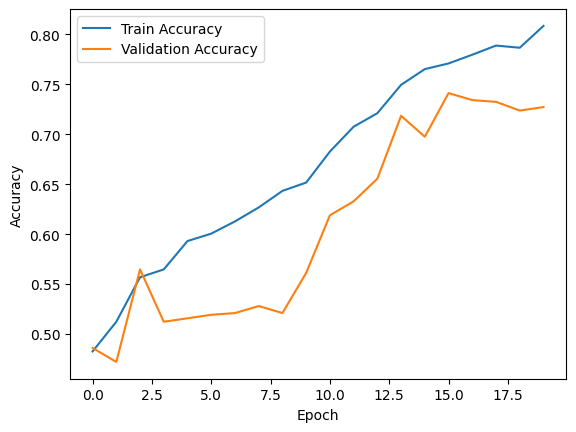

In [133]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()
